# RSI model-04
https://chatgpt.com/c/67fe98d5-33d4-800a-9af3-8004fb8cd47e

This model is designed to predict trend reversal points, not based on price predictions. In other words, the model is based on classification, not regression, and future prices are not accurate.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

In [4]:
# Load the 10-year training dataset
df = pd.read_csv("XAGUSD-H1-rates.csv", sep="\t")

# Combine Date and Time to datetime
df['DATETIME'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df.set_index('DATETIME', inplace=True)

# Use only the necessary columns
df = df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
df.columns = ['open', 'high', 'low', 'close', 'volume']

# Calculate RSI
rsi = RSIIndicator(close=df['close'], window=14).rsi()
df['rsi'] = rsi

# Drop rows with NaN
df.dropna(inplace=True)


In [6]:
def label_reversal_points(rsi_series, lower=30, upper=70):
    labels = np.zeros(len(rsi_series), dtype=int)
    for i in range(1, len(rsi_series)):
        if rsi_series[i - 1] < lower and rsi_series[i] >= lower:
            labels[i] = 1  # Buy signal
        elif rsi_series[i - 1] > upper and rsi_series[i] <= upper:
            labels[i] = 2  # Sell signal
    return labels

df['label'] = label_reversal_points(df['rsi'])


/tmp/ipykernel_7593/445066810.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rsi_series[i - 1] < lower and rsi_series[i] >= lower:
/tmp/ipykernel_7593/445066810.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif rsi_series[i - 1] > upper and rsi_series[i] <= upper:


In [7]:
# We will use 30 steps to predict the next 100
sequence_length = 30
forecast_horizon = 100

X = []
y = []

for i in range(sequence_length, len(df) - forecast_horizon):
    X.append(df.iloc[i-sequence_length:i][['open', 'high', 'low', 'close', 'volume', 'rsi']].values)
    y.append(df.iloc[i:i+forecast_horizon]['label'].values)

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y, num_classes=3)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 6)),
    Dropout(0.3),
    LSTM(64),
    Dense(100 * 3, activation='softmax')  # Predict 100 steps × 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape y to match output
y_train_reshaped = y_train.reshape((-1, 100 * 3))
y_test_reshaped = y_test.reshape((-1, 100 * 3))

model.fit(X_train, y_train_reshaped, epochs=10, batch_size=32, validation_split=0.1)


I0000 00:00:1744739688.384899    7593 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2067 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1744739691.336861    7716 cuda_dnn.cc:529] Loaded cuDNN version 90800


1237/1237 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0000e+00 - loss: 515.2877 - val_accuracy: 0.0000e+00 - val_loss: 581.1988
Epoch 2/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0000e+00 - loss: 605.8706 - val_accuracy: 0.0000e+00 - val_loss: 682.9518
Epoch 3/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0000e+00 - loss: 706.9253 - val_accuracy: 0.0000e+00 - val_loss: 784.6381
Epoch 4/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0000e+00 - loss: 808.5223 - val_accuracy: 0.0000e+00 - val_loss: 886.4202
Epoch 5/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0000e+00 - loss: 910.7203 - val_accuracy: 0.0000e+00 - val_loss: 988.3114
Epoch 6/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0000e+00 - loss: 1012.1205 - val_accuracy: 0.0000e+00 - val_loss: 1090.2391
Epoch 7/10
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0000e+00 - loss: 1113.0426 - val_accuracy: 0.0000e+00 - val_loss: 1192.0844
Epoch 8/10
1

In [14]:
# Load 30-hour new data
df_new = pd.read_csv("new-data-for-test/rows-30-from-20240503.csv", sep="\t")

In [ ]:
df_new['DATETIME'] = pd.to_datetime(df_new['<DATE>'] + ' ' + df_new['<TIME>'])

In [ ]:
df_new.set_index('DATETIME', inplace=True)
df_new = df_new[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
df_new.columns = ['open', 'high', 'low', 'close', 'volume']

In [10]:
# RSI
rsi_new = RSIIndicator(close=df_new['close'], window=14).rsi()
df_new['rsi'] = rsi_new
df_new.dropna(inplace=True)

X_input = df_new[['open', 'high', 'low', 'close', 'volume', 'rsi']].values[-30:]
X_input = np.expand_dims(X_input, axis=0)

prediction = model.predict(X_input)
predicted_classes = np.argmax(prediction.reshape((100, 3)), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


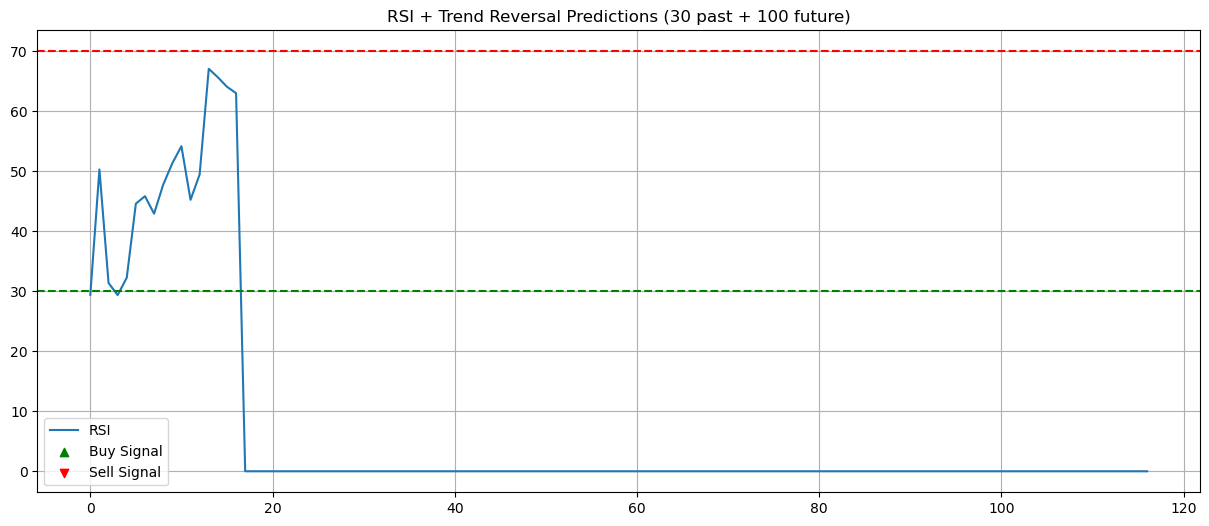

In [11]:
# Concatenate RSI of past 30 and dummy RSI for 100 future
rsi_full = np.concatenate([df_new['rsi'].values[-30:], np.zeros(100)])

# Create labels for visualization
buy_points = np.where(predicted_classes == 1)[0] + 30
sell_points = np.where(predicted_classes == 2)[0] + 30

plt.figure(figsize=(15, 6))
plt.plot(rsi_full, label='RSI')
plt.axhline(30, color='green', linestyle='--')
plt.axhline(70, color='red', linestyle='--')
plt.scatter(buy_points, rsi_full[buy_points], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_points, rsi_full[sell_points], marker='v', color='red', label='Sell Signal')
plt.title('RSI + Trend Reversal Predictions (30 past + 100 future)')
plt.legend()
plt.grid(True)
plt.show()